# Model training

References:

*  https://www.tensorflow.org/hub/tutorials/tf2_image_retraining



# Import necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
import tensorflow_datasets as tfds

!pip install --upgrade tensorflow_hub
!pip install eli5
import tensorflow_hub as hub
import eli5 # for GradCAM predictions


# Load data

In [ ]:
train_ds, validation_ds = tfds.load(
    "tf_flowers", split=["train[:85%]", "train[85%:]"], as_supervised=True
)

IMAGE_SIZE = (224, 224)
n_train, n_valid = 1000, 250

train_images, valid_images = [], []
train_labels, valid_labels = [], []
# 
for (image, label) in train_ds.take(n_train):
    image = tf.image.resize(image, IMAGE_SIZE)
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

for (image, label) in validation_ds.take(n_valid):
    image = tf.image.resize(image, IMAGE_SIZE)
    valid_images.append(image.numpy())
    valid_labels.append(label.numpy())

valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [ ]:
train_images[:5].shape, valid_images[:5].shape

((5, 224, 224, 3), (5, 224, 224, 3))

In [ ]:
train_labels[0]

2

# Visualise sample images

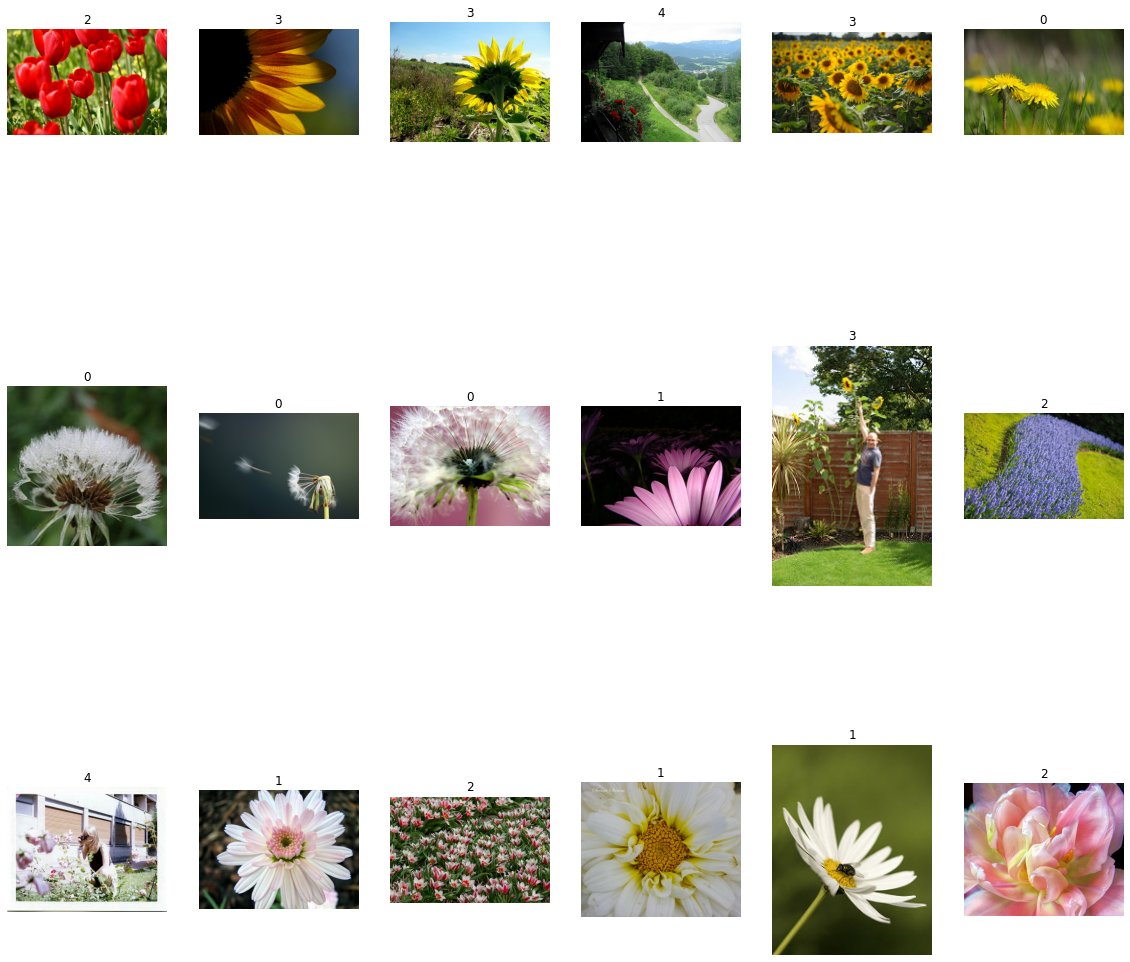

In [ ]:
# Visualization
plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(train_ds.take(18)):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
class_names = {
    0: 'dandelion',
    1: 'daisy',
    2: 'tulips',
    3: 'sunflowers',
    4: 'roses'
}

## Define necessary hyperparameters and pre-process dataset and get ready for training

In [ ]:
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]
BATCH_SIZE = 32
RESIZE_TO = 224
AUTO = tf.data.AUTOTUNE
SCHEDULE_LENGTH = (SCHEDULE_LENGTH * 512 / BATCH_SIZE) 

In [ ]:
# Preprocessing helper functions

# Create data pipelines for training and testing:

STEPS_PER_EPOCH = 10

DATASET_NUM_TRAIN_EXAMPLES = tf.data.experimental.cardinality(train_ds).numpy()
  
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_crop(image, [RESIZE_TO, RESIZE_TO, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

pipeline_train = (train_ds
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  
                  .map(preprocess_train, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

pipeline_test = (validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))


## Define model
Use InceptionResNetv2(pre-trained on ImageNet) and Transfer Learn on our flowers dataset

In [ ]:
from keras.applications import inception_resnet_v2
from tensorflow.keras import layers
from tensorflow.keras import Model
pretrainedModel = inception_resnet_v2.InceptionResNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)


#Making each layer non-trainable
for layer in pretrainedModel.layers:
  layer.trainable = False

#Printing the summary
pretrainedModel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
x = layers.GlobalAveragePooling2D()(pretrainedModel.output)
# Output classes = 5
x = layers.Dense(5, activation='softmax')(x)

model = Model(pretrainedModel.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Compile and fit

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, verbose=2, mode="auto",
    restore_best_weights=True
)

In [ ]:
hist = model.fit(
    pipeline_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    validation_data=pipeline_test,
    callbacks=[es]                                  
).history

Epoch 1/800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 42s 2s/step - loss: 1.3160 - accuracy: 0.4969 - val_loss: 0.7970 - val_accuracy: 0.6982
Epoch 2/800
10/10 [==============================] - 11s 1s/step - loss: 0.7171 - accuracy: 0.7375 - val_loss: 0.5535 - val_accuracy: 0.7836
Epoch 3/800
10/10 [==============================] - 11s 1s/step - loss: 0.6311 - accuracy: 0.7688 - val_loss: 0.4986 - val_accuracy: 0.8164
Epoch 4/800
10/10 [==============================] - 11s 1s/step - loss: 0.6046 - accuracy: 0.7719 - val_loss: 0.4652 - val_accuracy: 0.8164
Epoch 5/800
10/10 [==============================] - 11s 1s/step - loss: 0.4620 - accuracy: 0.8156 - val_loss: 0.4388 - val_accuracy: 0.8000
Epoch 6/800
10/10 [==============================] - 11s 1s/step - loss: 0.5156 - accuracy: 0.8094 - val_loss: 0.4449 - val_accuracy: 0.8255
Epoch 7/800
10/10 [==============================] - 11s 1s/step - loss: 0.5150 - accuracy: 0.8156 - val_loss: 0.4076 - val_accuracy: 0.8491
Epoch 8/800
10/10 [======

### Plot accuracy and loss curves

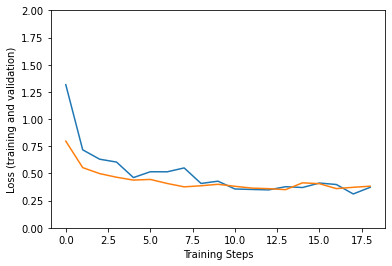

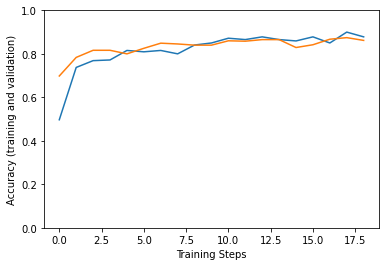

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

### Predict on unseen images

In [ ]:
# 10 sample predictions
predictions = model.predict(valid_images[:10] / 255.0)
for i in range(10):
  print(valid_labels[i], predictions[i], np.argmax(predictions[i]))

1 [0.19156973 0.6242233  0.11531077 0.01961371 0.04928244] 1
0 [9.83573675e-01 6.58241261e-05 7.01986486e-04 1.49816675e-02
 6.76857890e-04] 0
0 [0.781549   0.00159847 0.00376854 0.20956618 0.0035178 ] 0
2 [1.5934779e-04 1.3413744e-04 9.0224987e-01 3.7734117e-04 9.7079225e-02] 2
2 [4.6772020e-05 2.6252557e-04 9.9295056e-01 5.9837280e-03 7.5635663e-04] 2
1 [2.0170695e-01 7.9224116e-01 2.0125967e-03 3.9623408e-03 7.7069526e-05] 1
1 [5.2844145e-04 9.8671561e-01 8.9379821e-05 1.2652840e-02 1.3657385e-05] 1
4 [2.0845109e-03 9.2883041e-05 4.1046521e-01 1.1729105e-02 5.7562828e-01] 4
3 [0.09025115 0.00438081 0.00657785 0.883705   0.0150851 ] 3
3 [2.9159489e-04 1.4703823e-05 8.0736054e-06 9.9967980e-01 5.8179289e-06] 3


<class 'PIL.JpegImagePlugin.JpegImageFile'>


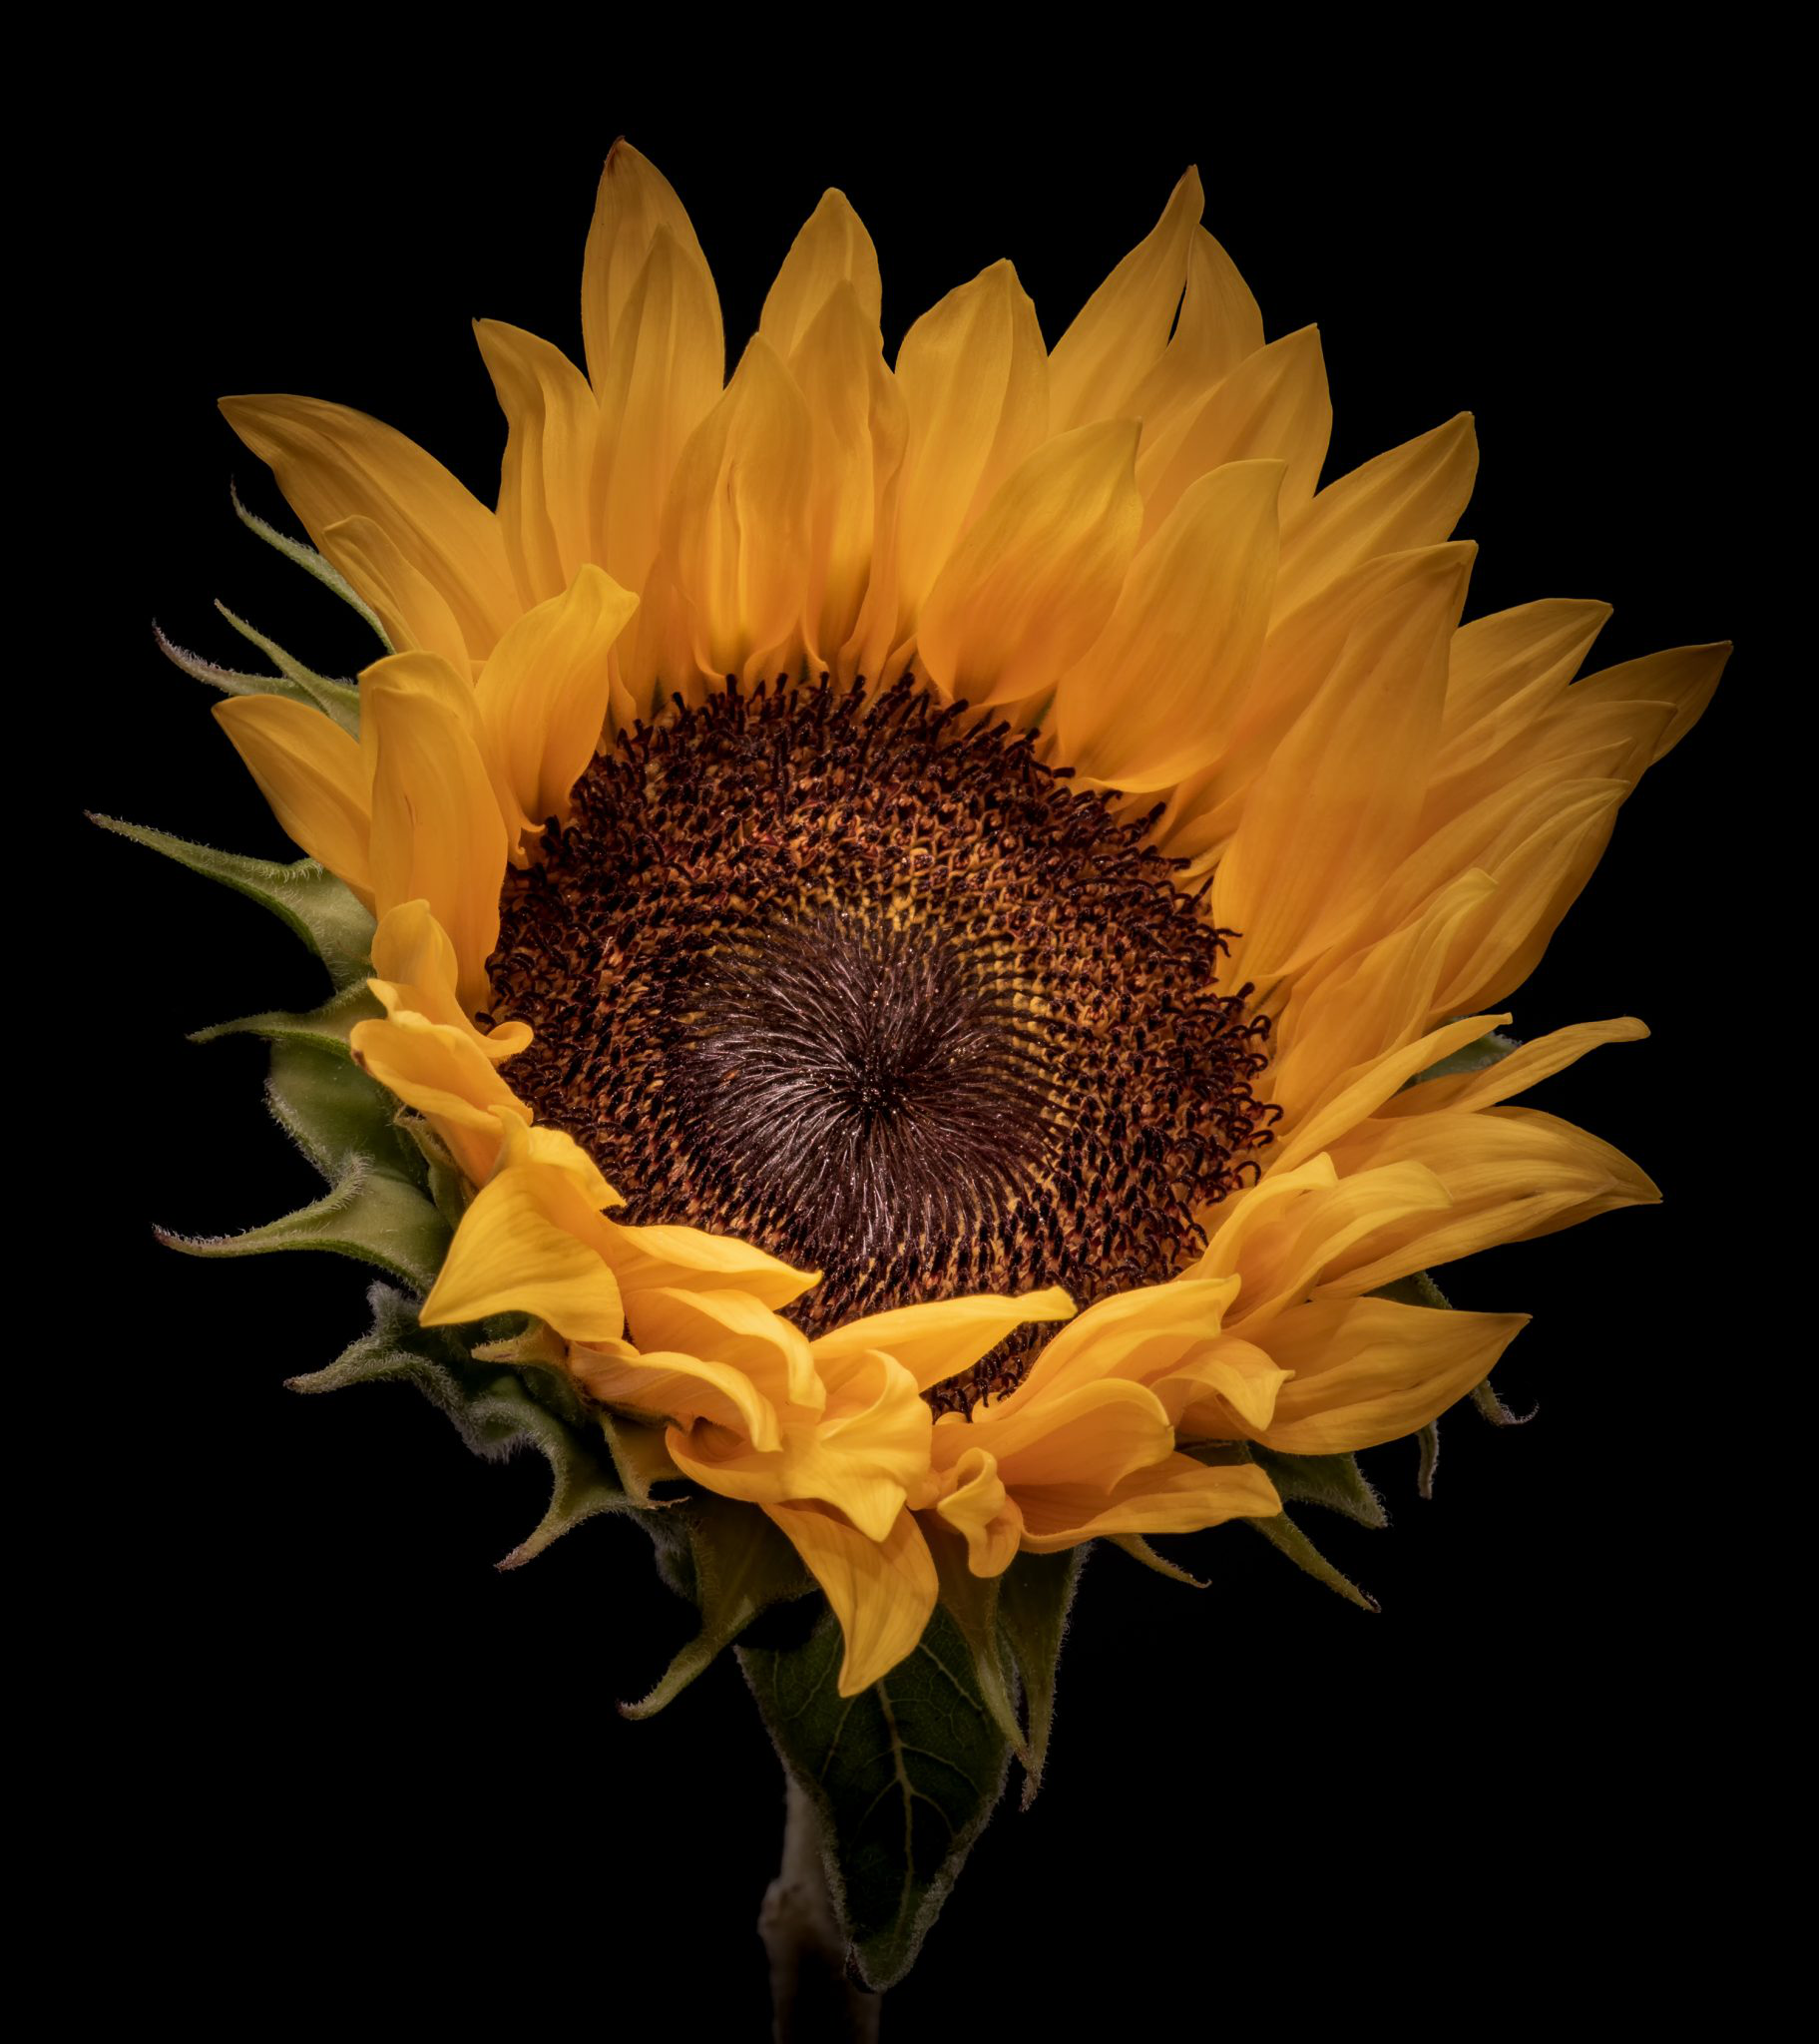

In [ ]:
# Empty
# Add code
from PIL import Image
import requests
from io import BytesIO

# Test image
image_uri = 'https://www.lovingly.com/wp-content/uploads/2020/05/AdobeStock_224192267.jpeg' # dandelion
response = requests.get(image_uri)
img = Image.open(BytesIO(response.content))

print(type(img))
display(img)


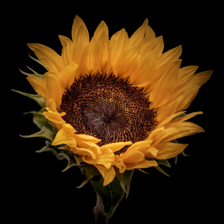

<class 'numpy.ndarray'> (224, 224, 3)
[[2.2506064e-02 5.9098406e-03 1.0577714e-03 9.7022748e-01 2.9878694e-04]]
Predicted label: sunflowers


In [ ]:
# Predict on test image
img = img.resize(IMAGE_SIZE)  # resize to (224, 224)
display(img)

doc = tf.keras.preprocessing.image.img_to_array(img) / 255.0 # -> numpy array
print(type(doc), doc.shape)

# Make predictions
prediction_scores = model.predict(np.expand_dims(doc, axis=0))
print(prediction_scores)
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

In [ ]:
model.layers

## Save model

In [ ]:
!mkdir -p saved_model
model.save('saved_model/ir2-flowers-model')

INFO:tensorflow:Assets written to: saved_model/ir2-flowers-model/assets


INFO:tensorflow:Assets written to: saved_model/ir2-flowers-model/assets


In [ ]:
# download model
!zip -r ir2-flowers-model.zip saved_model/ir2-flowers-model/
from google.colab import files
files.download("ir2-flowers-model.zip")

  adding: saved_model/ir2-flowers-model/ (stored 0%)
  adding: saved_model/ir2-flowers-model/saved_model.pb (deflated 92%)
  adding: saved_model/ir2-flowers-model/variables/ (stored 0%)
  adding: saved_model/ir2-flowers-model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/ir2-flowers-model/variables/variables.index (deflated 80%)
  adding: saved_model/ir2-flowers-model/assets/ (stored 0%)
  adding: saved_model/ir2-flowers-model/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>